In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [24]:
path_data = '../data/clean_data/application_train.csv'
variables = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'HOUR_APPR_PROCESS_START', 'AMT_ANNUITY', 'AMT_CREDIT','EXT_SOURCE_3',
            'EXT_SOURCE_2', 'CODE_GENDER', 'FLAG_PHONE', 'AMT_GOODS_PRICE', 'FLAG_OWN_CAR', 'NAME_FAMILY_STATUS', "TARGET"]
df = pd.read_csv(path_data)
df = df[variables]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_REQ_CREDIT_BUREAU_YEAR  265992 non-null  float64
 1   HOUR_APPR_PROCESS_START     307511 non-null  int64  
 2   AMT_ANNUITY                 307499 non-null  float64
 3   AMT_CREDIT                  307511 non-null  float64
 4   EXT_SOURCE_3                246546 non-null  float64
 5   EXT_SOURCE_2                306851 non-null  float64
 6   CODE_GENDER                 307511 non-null  object 
 7   FLAG_PHONE                  307511 non-null  int64  
 8   AMT_GOODS_PRICE             307233 non-null  float64
 9   FLAG_OWN_CAR                307511 non-null  object 
 10  NAME_FAMILY_STATUS          307511 non-null  object 
 11  TARGET                      307511 non-null  int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 28.2+ MB


In [25]:
df.head()

,AMT_REQ_CREDIT_BUREAU_YEAR,HOUR_APPR_PROCESS_START,AMT_ANNUITY,AMT_CREDIT,EXT_SOURCE_3,EXT_SOURCE_2,CODE_GENDER,FLAG_PHONE,AMT_GOODS_PRICE,FLAG_OWN_CAR,NAME_FAMILY_STATUS,TARGET
0,1.0,10,24700.5,406597.5,0.139376,0.262949,M,1,351000.0,N,Single / not married,1
1,0.0,11,35698.5,1293502.5,NaN,0.622246,F,1,1129500.0,N,Married,0
2,0.0,9,6750.0,135000.0,0.729567,0.555912,M,1,135000.0,Y,Single / not married,0
3,NaN,17,29686.5,312682.5,NaN,0.650442,F,0,297000.0,N,Civil marriage,0
4,0.0,11,21865.5,513000.0,NaN,0.322738,M,0,513000.0,N,Single / not married,0


## Feature Engineering

In [26]:
# etude de code_gender
print('Avant :', df['CODE_GENDER'].value_counts())
# En gardant seulement les lignes qui ne sont pas "XNA"
df = df[df['CODE_GENDER'] != 'XNA']
print('Après :', df['CODE_GENDER'].value_counts())

Avant : CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
Après : CODE_GENDER
F    202448
M    105059
Name: count, dtype: int64


In [27]:
(df.isna().mean() * 100)

AMT_REQ_CREDIT_BUREAU_YEAR    13.501806
HOUR_APPR_PROCESS_START        0.000000
AMT_ANNUITY                    0.003902
AMT_CREDIT                     0.000000
EXT_SOURCE_3                  19.825565
EXT_SOURCE_2                   0.214629
CODE_GENDER                    0.000000
FLAG_PHONE                     0.000000
AMT_GOODS_PRICE                0.090404
FLAG_OWN_CAR                   0.000000
NAME_FAMILY_STATUS             0.000000
TARGET                         0.000000
dtype: float64

In [28]:
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

In [29]:
print('Shape du data', df.shape)

Shape du data (307507, 13)


## Preprocessing

In [30]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

In [31]:
num_cols = [c for c in (df.select_dtypes(include=[np.number]).columns).tolist() if c != 'TARGET']
print(len(num_cols))

9


In [32]:
# types de variables dans nos données
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER           2
FLAG_OWN_CAR          2
NAME_FAMILY_STATUS    6
dtype: int64

In [33]:
# Définition nos colonnes
onehot_cols = ["CODE_GENDER", "FLAG_OWN_CAR", "NAME_FAMILY_STATUS"]

# Préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), onehot_cols),
        ("scaler", Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), num_cols)
    ]
)

### Separation des données

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state=42)

## Modelisation

In [37]:
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek

In [38]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

Meilleurs paramètres : {'estimator__colsample_bytree': 0.7, 'estimator__learning_rate': 0.02, 'estimator__max_depth': 5, 'estimator__min_child_samples': 20, 'estimator__n_estimators': 200, 'estimator__num_leaves': 127, 'estimator__subsample': 0.7}

In [40]:
gbm_model = Pipeline([
    ('preprocess', preprocessor),
    ('sampler', SMOTETomek(random_state=44)),
    ('estimator', LGBMClassifier(random_state=44,class_weight='balanced',scale_pos_weight=scale_pos_weight))
])

gbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 224956, number of negative: 224956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 449912, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,steps,"[('preprocess', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
def evaluation(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

    f1_scores = 2 * (prec * rec) / (prec + rec)
    best_threshold = thresholds[np.argmax(f1_scores)]

    print("Meilleur seuil :", best_threshold)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > best_threshold).astype(int)
    print(classification_report(y_test, y_pred))

In [42]:
evaluation(gbm_model, X_test, y_test)

c:\Users\laelo\AppData\Local\pypoetry\Cache\virtualenvs\projet-scoring-credit-ie2DxiSi-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Meilleur seuil : 0.8111610931139228
              precision    recall  f1-score   support

           0       0.95      0.83      0.88     56537
           1       0.19      0.46      0.27      4965

    accuracy                           0.80     61502
   macro avg       0.57      0.65      0.58     61502
weighted avg       0.89      0.80      0.83     61502



c:\Users\laelo\AppData\Local\pypoetry\Cache\virtualenvs\projet-scoring-credit-ie2DxiSi-py3.12\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Interprétation

In [43]:
importances = gbm_model.named_steps['estimator'].feature_importances_
feature_names = gbm_model.named_steps['preprocess'].get_feature_names_out()

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


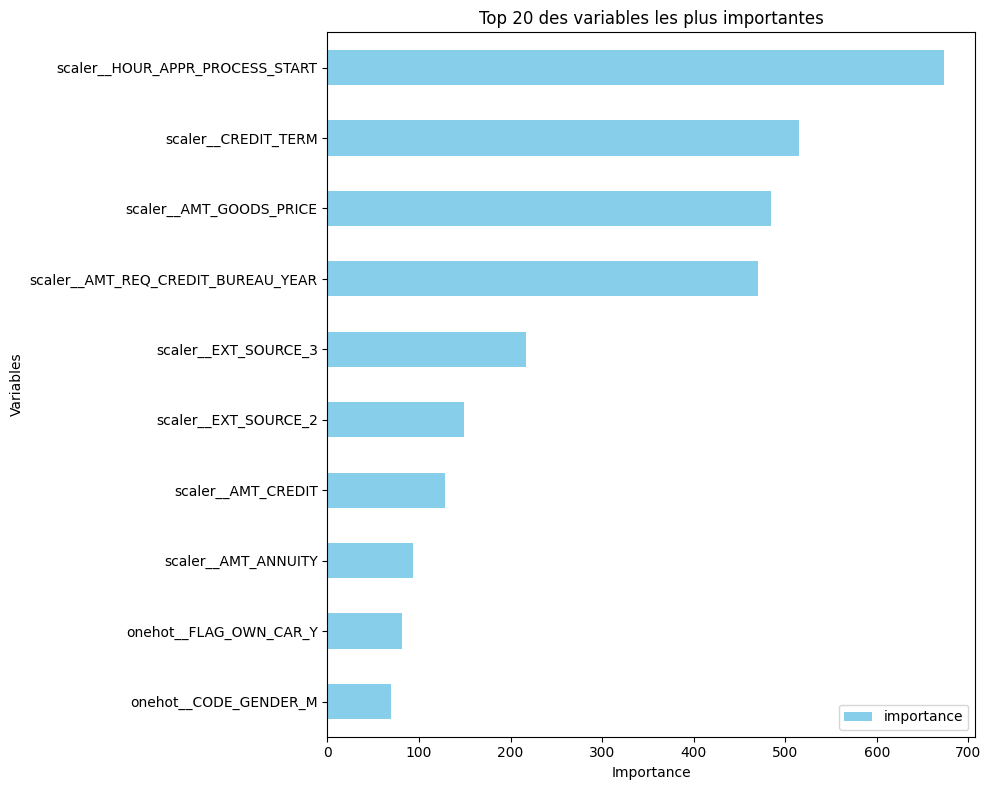

In [44]:
# Sélection des 20 premières variables 
top10 = feat_imp.head(10)
top10.sort_values("importance").plot(
    kind="barh",
    x="feature",
    y="importance",
    figsize=(10, 8),
    color="skyblue"
)
plt.title("Top 20 des variables les plus importantes")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


## Sauvegarde pour la mise en prod

In [45]:
import joblib
import json

In [46]:
# sauvegarde du model final 
final_model = Pipeline([
    ('preprocess', preprocessor),
    ('sampler', SMOTETomek(random_state=44)),
    ('estimator', LGBMClassifier(random_state=44,class_weight='balanced',scale_pos_weight=scale_pos_weight))
])

# on entrainne sur toutes nos données disponibles
final_model.fit(X, y)

[LightGBM] [Info] Number of positive: 281049, number of negative: 281049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 562098, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,steps,"[('preprocess', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
# Sauvegarde du modèle
joblib.dump(final_model, '../models/model.pkl')
inp_col = X.columns.tolist()

In [48]:
# Sauvegarde des métadonnées
metadata = {
    "author": 'Abdourahamane',
    'trained_on': "22-01-2026",
    "dataset_version": "application_train",
    'input_columns': inp_col

}

with open("../models/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)